In [1]:
!pip install transformers
!pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 16.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.18.1
    Uninstalling nvidia-nccl-cu12-2.18.1:
      Successfully uninstalled nvidia-nccl-cu12-2.18.1
  Attempting uninstall: torch
    Found existing ins

In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

DATA_DIR = "predict-energy-behavior-of-prosumers/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
client = pd.read_csv(os.path.join(DATA_DIR, "client.csv"))
historical_weather = pd.read_csv(os.path.join(DATA_DIR, "historical_weather.csv"))
forecast_weather = pd.read_csv(os.path.join(DATA_DIR, "forecast_weather.csv"))
electricity = pd.read_csv(os.path.join(DATA_DIR, "electricity_prices.csv"))
gas = pd.read_csv(os.path.join(DATA_DIR, "gas_prices.csv"))
location = pd.read_csv(os.path.join(DATA_DIR, "county_lon_lats.csv")).drop(columns=["Unnamed: 0"])


class FeatureProcessorClass():
    def __init__(self):
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']

        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']

        # Aggregate stats
        self.agg_stats = ['mean']  # , 'min', 'max', 'std', 'median']

        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col) > 0])
                      for multi_col in df.columns]
        return df

    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])

        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour

        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month'] = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client,
                                              suffix='_client',
                                              columns_no_change=self.client_join
                                              )
        return client

    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''

        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how='left', on=self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change=self.lat_lon_columns + self.weather_join
                                                          )

        # Group by & calculate aggregate stats
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index()

        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather)

        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                          .apply(lambda x:
                                                 x['datetime'] + pd.DateOffset(1)
                                                 if x['hour_h'] < 11
                                                 else x['datetime'] + pd.DateOffset(2),
                                                 axis=1)
                                          )

        return historical_weather

    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''

        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns={'forecast_datetime': 'datetime'})
                            .drop(columns='origin_datetime')  # not needed
                            )

        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                        )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how='left', on=self.lat_lon_columns)

        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change=self.lat_lon_columns + self.weather_join
                                                        )

        # Group by & calculate aggregate stats
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index()

        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])

        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)

        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity,
                                                   suffix='_electricity',
                                                   columns_no_change=self.electricity_join
                                                   )
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh']) / 2

        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas,
                                           suffix='_gas',
                                           columns_no_change=self.gas_join
                                           )
        return gas

    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)

        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on=self.client_join)
        df = df.merge(historical_weather, how='left', on=self.weather_join)
        df = df.merge(forecast_weather, how='left', on=self.weather_join)
        df = df.merge(electricity, how='left', on=self.electricity_join)
        df = df.merge(gas, how='left', on=self.gas_join)

        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df


def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()

    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags + 1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets,
                          how='left',
                          on=['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes=('', f'_{day_lag}_days_ago')
                          )
    return data


N_day_lags = 16 # Specify how many days we want to go back (at least 2)

FeatureProcessor = FeatureProcessorClass()

data = FeatureProcessor(data=train.copy(),
                        client=client.copy(),
                        historical_weather=historical_weather.copy(),
                        forecast_weather=forecast_weather.copy(),
                        electricity=electricity.copy(),
                        gas=gas.copy(),
                        )

data = create_revealed_targets_train(data.copy(), N_day_lags=N_day_lags)
print(data.shape[0])

2018352


In [13]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from accelerate import Accelerator
from sklearn.model_selection import train_test_split

df = data[data['is_consumption'] == 1]
df = df.dropna()

# Extract features, target, and past values
feature = df.drop(columns=['target', 'row_id', 'datetime', 'data_block_id', 'prediction_unit_id',
                           'date', 'date_client', 'forecast_date_electricity', 'origin_date_electricity',
                           'forecast_date_gas', 'origin_date_gas', 'target_2_days_ago', 'target_3_days_ago',
                           'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago',
                           'target_8_days_ago', 'target_9_days_ago', 'target_10_days_ago', 'target_11_days_ago',
                           'target_12_days_ago', 'target_13_days_ago', 'target_14_days_ago', 'target_15_days_ago']
                  ).values
target_array = df['target'].values
past_value_array = df[['target_2_days_ago', 'target_3_days_ago',
                       'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago',
                       'target_8_days_ago', 'target_9_days_ago', 'target_10_days_ago', 'target_11_days_ago',
                       'target_12_days_ago', 'target_13_days_ago', 'target_14_days_ago', 'target_15_days_ago']].values

# Prepare features and tensors
features = feature
past_time_features_list = []
future_time_features_list = []

for i in range(len(features) - 14):
    past_time_features_list.append(features[i:i+14])

past_time_features = np.array(past_time_features_list, dtype=np.float32)

for i in range(14, len(features) - 7):
    future_time_features_list.append(features[i:i+7])

future_time_features = np.array(future_time_features_list, dtype=np.float32)


past_time_features_tensor = torch.tensor(past_time_features, dtype=torch.float)
future_time_features_tensor = torch.tensor(future_time_features, dtype=torch.float)

past_values_adjusted = np.array([target_array[i:i+14] for i in range(len(target_array) - 14)])
future_values_adjusted = np.array([target_array[i:i+7] for i in range(14, len(target_array) - 7)])

past_time_features_tensor = torch.tensor(past_time_features, dtype=torch.float)[:-(14+7)]
future_time_features_tensor = torch.tensor(future_time_features, dtype=torch.float)

past_values_tensor = torch.tensor(past_values_adjusted, dtype=torch.float)[:-(14+7)]
future_values_tensor = torch.tensor(future_values_adjusted, dtype=torch.float)

# Split the dataset into train and test (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(past_time_features_tensor, past_values_tensor, test_size=0.2, random_state=42)

# Create PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, past_time_features, past_values, future_time_features, future_values):
        self.past_time_features = past_time_features
        self.past_values = past_values
        self.future_time_features = future_time_features
        self.future_values = future_values
        self.past_observed_mask = torch.ones_like(self.past_values)

    def __len__(self):
        return len(self.past_time_features)

    def __getitem__(self, idx):
        return {
            'past_time_features': self.past_time_features[idx],
            'past_values': self.past_values[idx],
            'past_observed_mask': self.past_observed_mask[idx],
            'future_time_features': self.future_time_features[idx],
            'future_values': self.future_values[idx]
        }

# Create datasets and dataloaders for train and test
train_dataset = TimeSeriesDataset(X_train, y_train, future_time_features_tensor, future_values_tensor)
test_dataset = TimeSeriesDataset(X_test, y_test, future_time_features_tensor, future_values_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Configure model and optimizer
config = TimeSeriesTransformerConfig(
    input_size=1,
    prediction_length=7,
    lags_sequence=[1, 2, 3, 4, 5, 6, 7],
    num_time_features=47,
    dropout=0.1,
    encoder_layers=2,
    decoder_layers=2,
    d_model=64,
)

model = TimeSeriesTransformerForPrediction(config)

accelerator = Accelerator()
device = accelerator.device
model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

# Training loop (adjust the number of epochs as needed)
model.train()
for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        # print(batch["past_time_features"].shape)
        # print(batch["past_values"].shape)
        # print(batch["future_time_features"].shape)
        # print(batch["future_values"].shape)
        # print(batch["past_observed_mask"].shape)
        optimizer.zero_grad()
        outputs = model(
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device)
        )
        loss = outputs.loss

        accelerator.backward(loss)
        optimizer.step()

        if idx % 1000 == 0:
            print(loss.item())

# Evaluation loop
model.eval()
forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


7.746611595153809
5.870579242706299
5.630244731903076
5.501615047454834
5.472752094268799
5.444023132324219
5.320937156677246
5.3843865394592285
5.505728721618652
5.237590312957764


In [19]:
print(forecasts[0].shape)
print(len(forecasts))

gt = []
for batch in test_dataloader:
    gt.append(batch["future_values"])
print(gt[0].shape)
print(len(gt))

(64, 100, 7)
81
torch.Size([64, 7])
81


In [21]:
forecasts_array = np.vstack(forecasts)
print(forecasts_array.shape)
forecast_median = np.median(forecasts_array, 1)
print(forecast_median.shape)
gt_array = np.vstack(gt)
print(gt_array.shape)

(5164, 100, 7)
(5164, 7)
(5164, 7)


In [35]:
from sklearn.metrics import mean_absolute_error

# Calculate the MAE
def calculate_mae(forecast, ground_truth):
    mae = mean_absolute_error(forecast, ground_truth)
    return mae

mae = calculate_mae(forecast_median, gt_array)
print("MAE:", mae)

MAE: 178.84224


In [23]:
# Calculate MAE for each time step and each sample
mae = np.abs(forecast_median - gt_array)

# Calculate MAE for each time step across all samples
mae_across_time = np.mean(mae, axis=0)

# Calculate the seasonal naive forecast (e.g., using previous season's values)
seasonal_naive_forecast = gt_array[:-1, :]

# Calculate MAE for each time step and each sample for the seasonal naive forecast
mae_seasonal_naive = np.abs(seasonal_naive_forecast - gt_array[1:, :])

# Calculate MAE for each time step across all samples for the seasonal naive forecast
mae_seasonal_naive_across_time = np.mean(mae_seasonal_naive, axis=0)

# Calculate MASE for each time step
mase = mae_across_time / mae_seasonal_naive_across_time

# Calculate the overall MASE (mean across time steps)
overall_mase = np.mean(mase)

print("MASE for each time step:", mase)
print("Overall MASE:", overall_mase)

MASE for each time step: [0.33169866 0.32691872 0.33036742 0.33892664 0.33422962 0.3376545
 0.33268073]
Overall MASE: 0.33321092


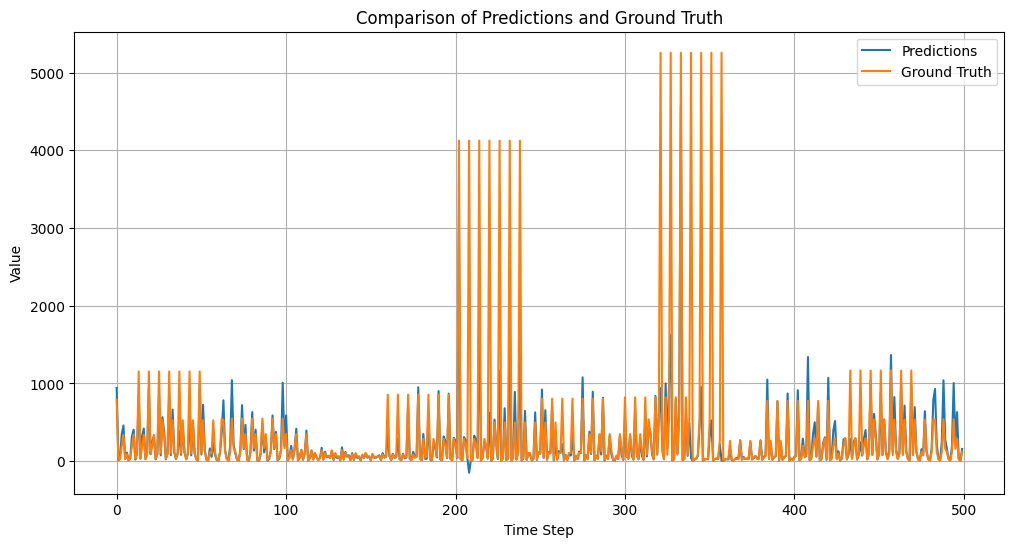

In [38]:
import matplotlib.pyplot as plt

forecast_median = forecast_median.flatten()
gt_array = gt_array.flatten()

time_steps = range(500)

# Plot the forecasts and ground truth with lines connecting the points
plt.figure(figsize=(12, 6))
plt.plot(time_steps, forecast_median[:500], label='Predictions', linestyle='-')
plt.plot(time_steps, gt_array[:500], label='Ground Truth', linestyle='-')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of Predictions and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()
